# Introduction

## Imports

In [1]:
%matplotlib inline

import os

import pickle as pkl
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

from mpl_toolkits.mplot3d import axes3d, Axes3D 

from SCT_segmentation import data as dm
from SCT_segmentation import SCT_API as sct
from SCT_segmentation import GM_analysis as gma

## Variables Globales

In [2]:
#matplotlib config
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['font.size'] = 20

#Emplacement des données
data_path = "../images_db/"

SCT_path = data_path+"SCT/"

training_sct_masks_path = SCT_path+"training_masks/"    #masques générés par Spinal Cord Toolbox
test_sct_masks_path = SCT_path+"test_masks/"

train_img_path = data_path+"training-data-gm-sc-challenge-ismrm16-v20160302b/"  #Donnée d'IRM du Spinal cord grey matter segmentation challenge
test_img_path = data_path+"test-data-gm-sc-challenge-ismrm16-v20160401/"

stat_folder_path = "stat_files/"


## Chargement des données

In [3]:
file_tree = dm.load_training_files(train_img_path)  #Organisations des différents fichiers dans un dictionnaire

Les fichiers sont regroupés selon le site où a été réalisée l'IRM, pour les données d'entraînement il a 10 IRM par site (sc01, sc02, etc.). Pour chaque IRM on considère le fichier "image", le nombre de tranches qu'il contient, les niveau auxquelles elles ont été prise (chiffre correspondant à la cervicale aux niveau de laquelle a été pris la tranche), ainsi que les fichiers des masques qui ont été réalisés par des expert et qui délimitent différentes régions de la colonne vertébrale. 

In [4]:
print(file_tree.keys())
print(file_tree['site2'].keys())
print(file_tree['site2']['sc01'].keys())

dict_keys(['site1', 'site2', 'site3', 'site4'])
dict_keys(['sc01', 'sc02', 'sc03', 'sc04', 'sc05', 'sc06', 'sc07', 'sc08', 'sc09', 'sc10'])
dict_keys(['name', 'image', 'slice_nbr', 'levels', 'masks'])


On voit par exemple ici 3 tranches réalisés au site 4 (Université de Vanderbilt aux Etats-Unis) prises au niveau de la cervicale 2 et dans le disque entre les cervicales 2 et 3 :

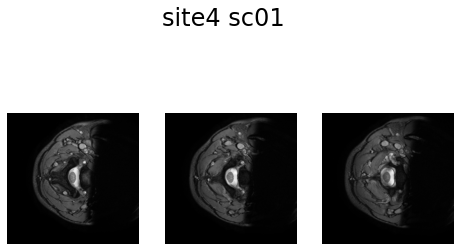

In [5]:
ex_scan = file_tree['site4']['sc01']

dm.plot_slices(ex_scan, levels=[2])

Ici on peut voir les masques réalisés par les experts des sites 1 et 2 (University College de Londres et Polytechnique Montréal respectivement) pour ces 3 mêmes tranches :

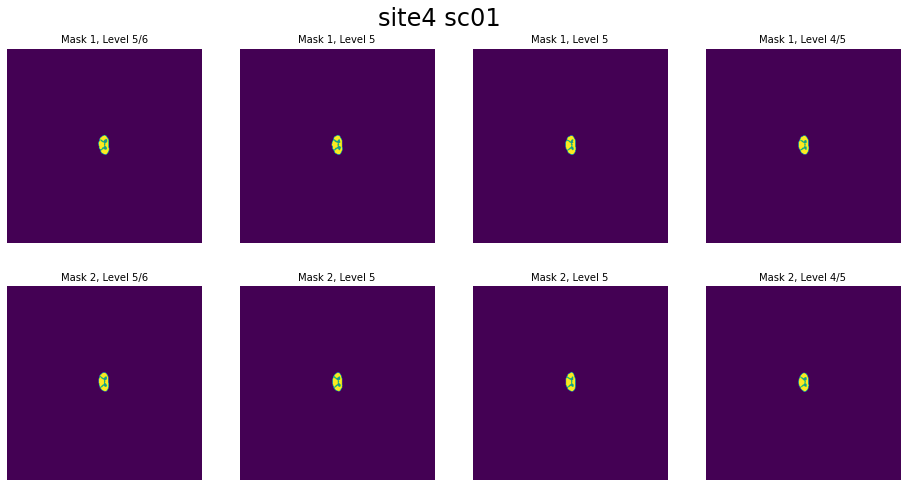

In [6]:
dm.plot_masks(ex_scan, masks=[0,1], levels=[5])

On remarque que cette segmentation est composée de 2 parties distinctes, d'une part la matière grise qui correspond à la moëlle épinière et d'autre part la matière blanche qui correspond au reste de la tranche de la colonne vertébrale. Dans le reste de l'étude nous nous intéresserons exclusivement à la segmentation de la matière grise.

Valeurs du masque :  [0. 1. 2.]


(-0.5, 511.5, 511.5, -0.5)

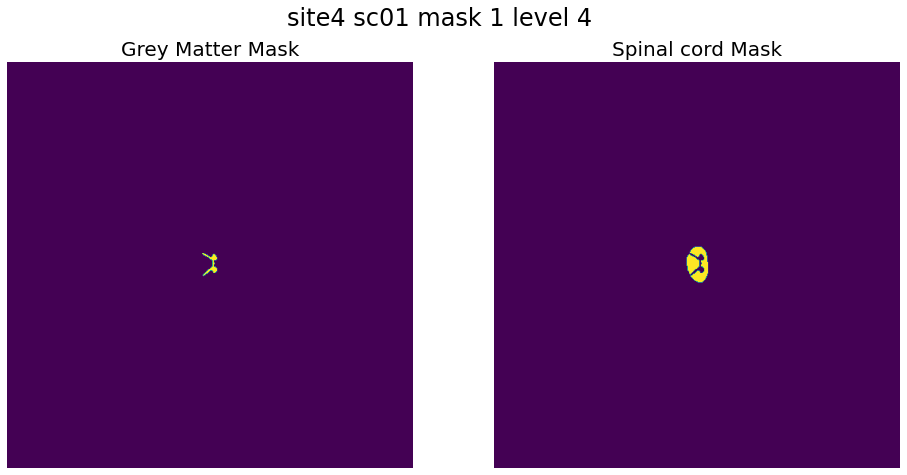

In [7]:
data = nib.load(ex_scan['masks'][1])
slices = data.get_fdata()
print('Valeurs du masque : ', np.unique(slices))

fig, axs = plt.subplots(1, 2)
fig.suptitle(ex_scan['name']+' mask 1 level '+ ex_scan['levels'][5], y=.95)

axs[0].imshow(np.where(slices[:,:,5] == 1., 1, 0))
axs[0].set_title('Grey Matter Mask', fontsize=20)
axs[0].axis('off')

axs[1].imshow(np.where(slices[:,:,5] == 2., 1, 0))
axs[1].set_title('Spinal cord Mask', fontsize=20)
axs[1].axis('off')

En comparant les segmentations des différents experts sur la même tranche on remarques que c'est un problème difficile à quantifier précisément

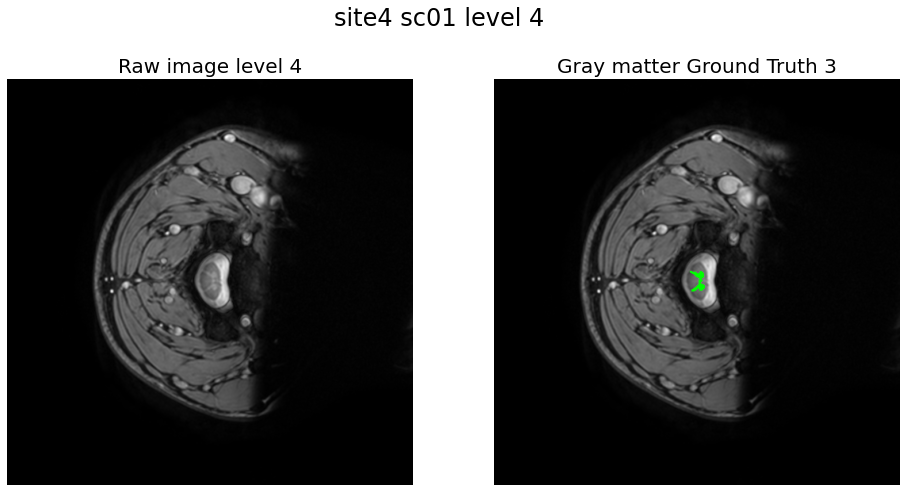

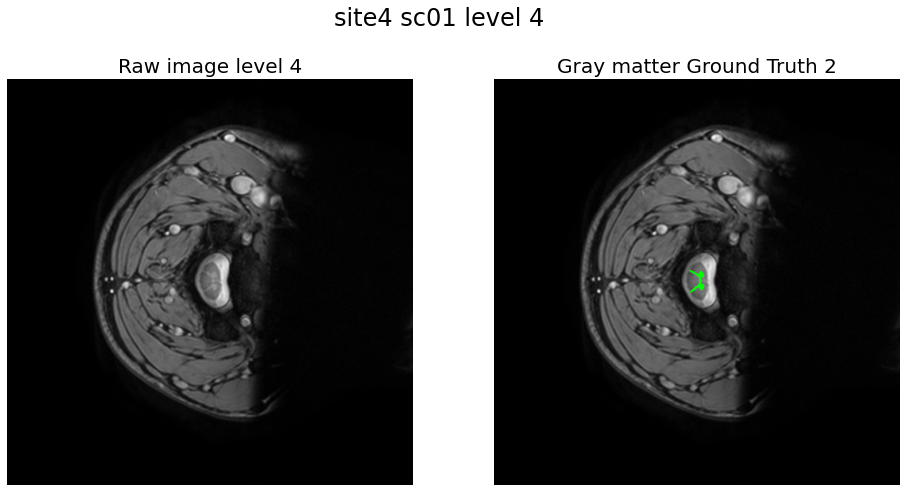

In [8]:
dm.plot_gm_ground_truth(ex_scan, mask=2, slice=5)
dm.plot_gm_ground_truth(ex_scan, mask=1, slice=5)

# Segmentation de la moelle épinière

Pour réaliser la segmentation de la matière grise nous allons utiliser Spinal Cord Toolbox (SCT) qui est un programme open source proposant différents outils d'analyse d'IRMs de colonne vertébrale. Dans le cadre de cette étude nous allons nous limiter à ses capacités de segmentation.

In [9]:
sct.make_gm_seg(ex_scan, training_sct_masks_path)

GM Segmentation already exists


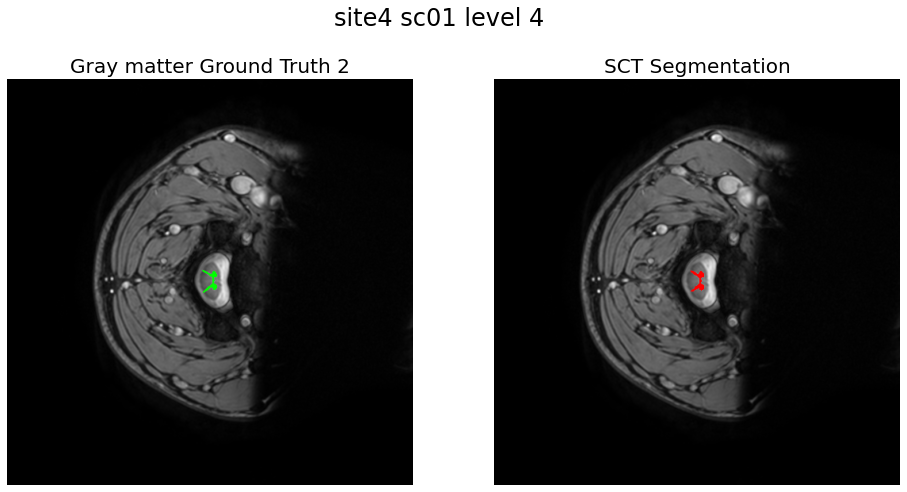

In [10]:
dm.plot_sct_seg_and_gt(ex_scan, mask=1, slice=5)

La segmentation est réalisée tranche par tranche pour chaque volume. Elle prend environ 4 secondes par tranche sur une machine avec un processeur Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz et une carte graphique Nvidia GeForce 1050. Les jeux de données d'entraînement et de test ont respectivement environ 560 tranches chacuns répartie entre 40 IRMs et la segmentation de l'ensemble d'un jeu prend environ 45 minutes soit 1 heure 30 en tout.

## Analyse de la segmentation

Ici nous allons étudier la pertinence de la segmentation réalisée par SCT par rapport à la segmentation réalisée par des experts. Pour celà nous allons utiliser 2 métriques:

- La première est le Dice Score qui mesure la superposition des surfaces des masques. Elle nous permettra d'estimer le niveau de certitude avec lequel le masque recouvre bien de la matière grise.

- La seconde est la distance de Hausdorff qui mesure le plus grand écart entre deux masques. Elle nous permettra d'estimer la confiance qu'on peut avoir dans l'analyse de la forme du masque SCT.


Afin d'estimer la performance de SCT nous allons appliquer ces métriques tranche par tranche sur les section orthogonales à la colonne vertébrale car c'est ainsi que les masques sont réalisés par l'algorithme et car c'est aussi ainsi qu'elles sont exploitée pour détecter des lésions, cependant il ne faut pas oublier qu'ils s'agit de volumes et que l'on pourrait choisir des coupes selons un autre axe.

In [11]:
ex_scan2 = file_tree['site3']['sc01']

train_file_tree = dm.load_files(train_img_path, training_sct_masks_path)

haus_scores = gma.hausdorff_score(ex_scan, 0)

print('Hausdorff distances : ')
print(haus_scores)

dice_scores = gma.dice_score(ex_scan, 0)

print('Dice scores : ')
print(dice_scores)

print(sum(x > 0 for x in dice_scores))

Hausdorff distances : 
[1.4142135623730951, 1.4142135623730951, 2.0, 1.0, 1.4142135623730951, 2.8284271247461903, 1.4142135623730951, 2.8284271247461903, 1.4142135623730951, 2.23606797749979, 1.0, 1.4142135623730951]
Dice scores : 
[0.8973747016706444, 0.8807785888077859, 0.8763440860215054, 0.8839779005524862, 0.896551724137931, 0.8427299703264095, 0.8706624605678234, 0.8402777777777778, 0.8467153284671532, 0.8389513108614233, 0.916083916083916, 0.8551236749116607]
12


On remarque ici que les scores pour certaines tranches sont nuls, cela est dû au fait que certaines tranches ne présentent pas de matière grise à segmenter, il y a donc ni masque d'expert ni masque de segmentation SCT à comparer. Dans la suite nous calculons le score moyen sur toute les tranches contenant de la matière grise pour chaque IRM.

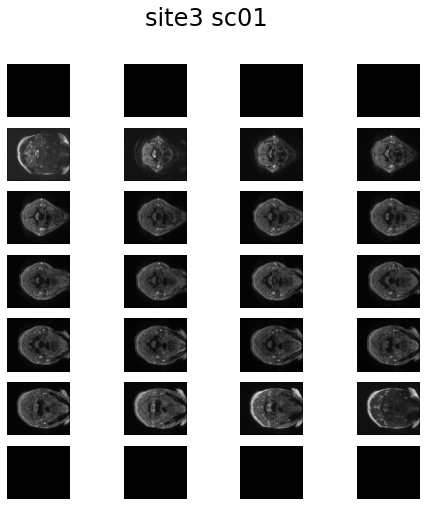

In [12]:
dm.plot_slices(ex_scan2)

Nous avons ici le score Dice moyen ainsi que la distance de Hausdorff moyenne de la segmentation SCT par rapport aux segmentations réalisées par les différents experts :

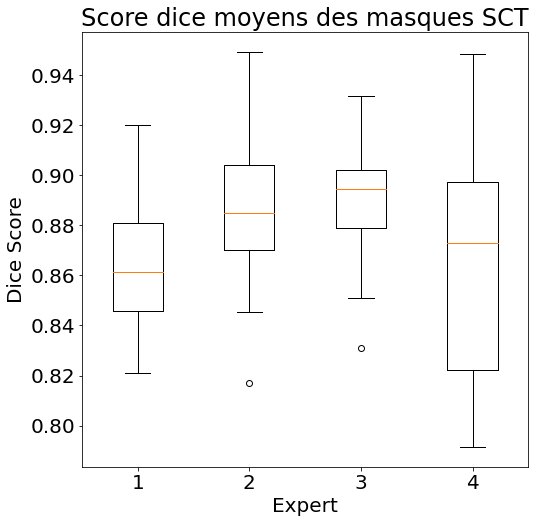

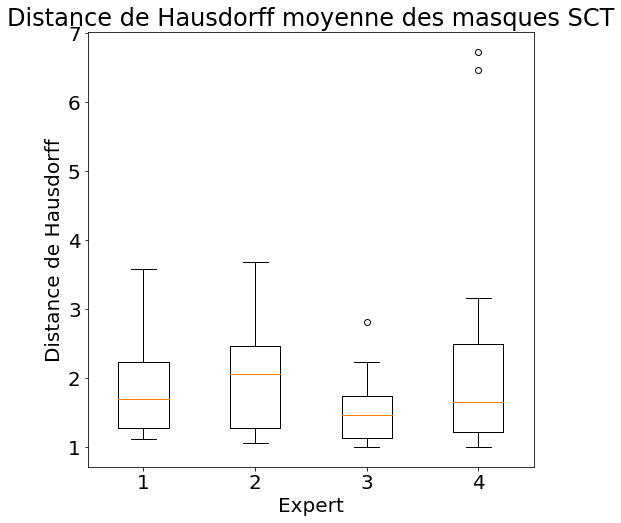

Dice score moyen : 0.8759738983859925
Distance de Hausdorff moyenne : 1.8341304243906047 pixels


In [13]:
seg_stats_file = open(stat_folder_path+"sct_seg_scores.pkl", "rb")
seg_stats = pkl.load(seg_stats_file)
seg_stats_file.close()

avg_dice_scores = {}
avg_haus_scores = {}

for mask in seg_stats.keys():
    avg_dice_scores[mask] = []
    avg_haus_scores[mask] = []
    
    for site in seg_stats[mask].keys():
        for sc in seg_stats[mask][site].keys():
            avg_dice_scores[mask].append(seg_stats[mask][site][sc]['dice_score'])
            avg_haus_scores[mask].append(seg_stats[mask][site][sc]['haus_score'])
            
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.set_title('Score dice moyens des masques SCT')
ax1.set_xlabel('Expert')
ax1.set_ylabel('Dice Score')
ax1.boxplot([avg_dice_scores[mask] for mask in avg_dice_scores.keys()])
plt.show()

fig2, ax2 = plt.subplots(figsize=(8,8))
ax2.set_title('Distance de Hausdorff moyenne des masques SCT')
ax2.set_xlabel('Expert')
ax2.set_ylabel('Distance de Hausdorff')
ax2.boxplot([avg_haus_scores[mask] for mask in avg_dice_scores.keys()])
plt.show()

print("Dice score moyen : "+str(np.mean([np.mean(avg_dice_scores[mask]) for mask in avg_dice_scores.keys()])))
print("Distance de Hausdorff moyenne : "+str(np.mean([np.mean(avg_haus_scores[mask]) for mask in avg_haus_scores.keys()]))+" pixels")


Les masques produits par SCT ont donc un score Dice moyen d'environ 0.88 avec les masks d'expert ce qui signifie que si on analyse les valeurs de l'IRM dans ces masks entre 80 et 90 % devraient être de la matière grise ce qui est suffisant pour extraire des informations pertinentes.

De plus la distance de Haufdorff moyenne est inférieure à 2 pixels et est majoritairement inférieure à 3 pixels (sauf quelques exceptions qui peuvent monter à 7 pixels ce qui significatif en vue de la petite taille de la matière grise sur les IRM). Cela signifie que la forme globale du mask est très proche de la forme de la matière grise et peut donc être analysée pour chercher des déformations.

Par ailleurs on remarque que les masques SCT sont particulièrement semblables à ceux l'expert 3 de l'université de Zurich et ont des scores en accord avec l'état de l'art publier avec le jeu de données étudié.


Pour avoir une base de comparaison, nous pouvons aussi étudier les scores Dice et les distance de Hausdorff calculés entres les différents masques experts.

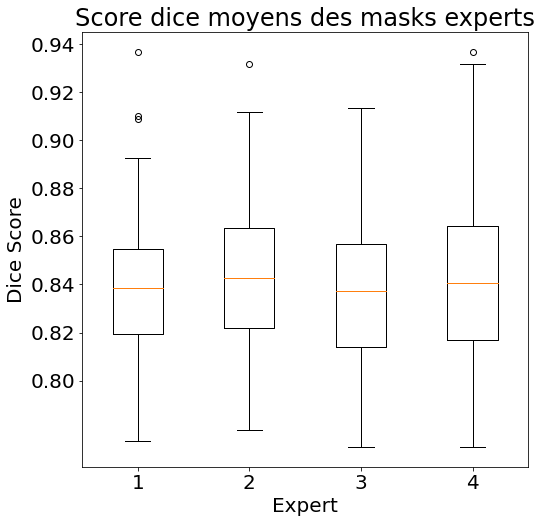

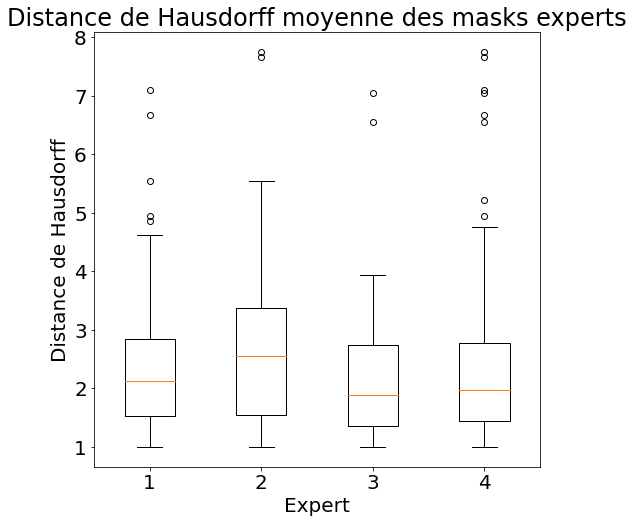

Dice score moyen : 0.8398463440202211
Distance de Hausdorff moyenne : 2.3850659505732903 pixels


In [14]:
mask_stats_file = open(stat_folder_path+"mask_cross_scores.pkl", "rb")
mask_cross_stats = pkl.load(mask_stats_file)
mask_stats_file.close()

avg_dice_scores = {}
avg_haus_scores = {}


for mask in mask_cross_stats.keys():
    avg_dice_scores[mask] = []
    avg_haus_scores[mask] = []
    
    for m in mask_cross_stats[mask].keys():
        for site in mask_cross_stats[mask][m].keys():
            for sc in mask_cross_stats[mask][m][site].keys():
                avg_dice_scores[mask].append(mask_cross_stats[mask][m][site][sc]['dice_score'])
                avg_haus_scores[mask].append(mask_cross_stats[mask][m][site][sc]['haus_score'])
            
fig3, ax3 = plt.subplots(figsize=(8,8))
ax3.set_title('Score dice moyens des masks experts')
ax3.set_xlabel('Expert')
ax3.set_ylabel('Dice Score')
ax3.yaxis.set_ticks([0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94])
ax3.boxplot([avg_dice_scores[mask] for mask in avg_dice_scores.keys()])
plt.show()

fig4, ax4 = plt.subplots(figsize=(8,8))
ax4.set_title('Distance de Hausdorff moyenne des masks experts')
ax4.set_xlabel('Expert')
ax4.set_ylabel('Distance de Hausdorff')
ax4.boxplot([avg_haus_scores[mask] for mask in avg_dice_scores.keys()])
plt.show()

print("Dice score moyen : "+str(np.mean([np.mean(avg_dice_scores[mask]) for mask in avg_dice_scores.keys()])))
print("Distance de Hausdorff moyenne : "+str(np.mean([np.mean(avg_haus_scores[mask]) for mask in avg_haus_scores.keys()]))+" pixels")


On remarque que les masques d'experts présentent beaucoup plus de variations entre eux que les masques SCT avec ces derniers que ce soit en superpositions que en déformation. Cela témoigne d'une robustesse de l'algorithme de segmentation SCT.

## Extractions et analyse de propriétés de la moelle épinière

Afin de pouvoir déter des anomalies dans la matières grise, nous alons quantifier 3 des ses propriété : 
- La densité, elle sera estimée en prennant la valeur moyenne de l'IRM sur l'ensemble du masque SCT
- la texture, elle sera estimée en étudiant l'écart type des valeurs l'IRM dans le masque SCT
- la forme, il s'agit ici un écart de la forme par rapport à la "normale". Cela peut être estimée en calculant la distance de Hausdorff du masque SCT squelettisé au squelette du masque moyen couvrant de la matière grise pris sur l'ensemble des données. 

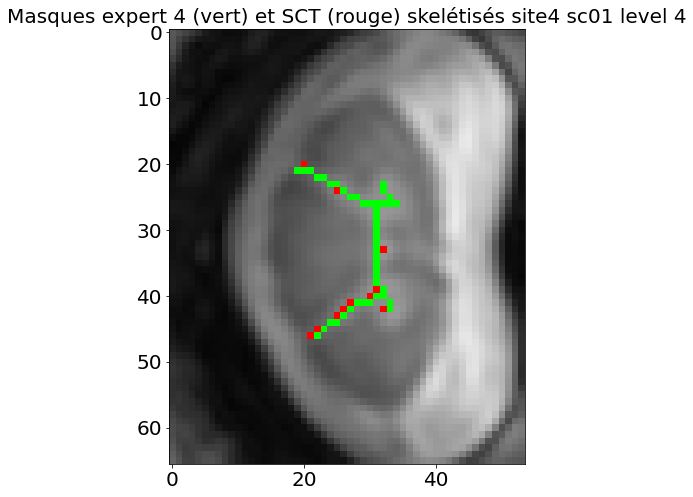

Distance de Hausdorff skeletisée :  1.4142135623730951


In [15]:
dm.plot_sklt_sct_masks(ex_scan, mask=3, slice=5)

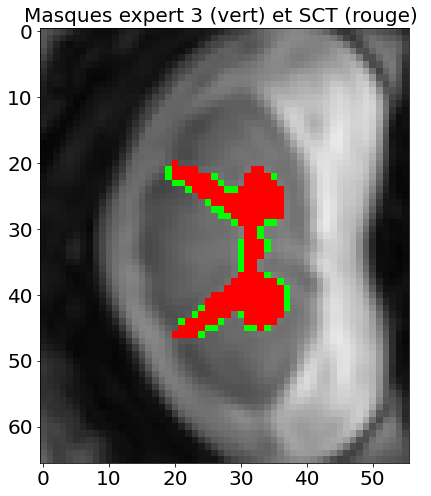

site4 sc01 level 4
Distance de Hausdorff skeletisée :  1.4142135623730951
Score Dice :  0.8780487804878049


In [16]:
dm.plot_sct_masks_overlap(ex_scan, mask=2, slice=5)

Nour déterminer un squelette de référence fiable, nous allons utiliser les masques réalisés par l'expert du site 3. Utiliser les masques d'un expert nous assure de leur fiabilité, et l'expert du site a été choisi car ses masques ont le plus de similarité avec ceux de SCT. Les masques moyens sont obtenus en centrant et superposant tous les masques de matière grises pour chaque tranche de chaque IRM site par site. On remarque que ces squelettes sont de tailles différentes car les différents sites utilisent des scanners avec des résolutions différentes, les différents masques sont donc squelettisés séparément pour avoir un squelette de référence par site ainsi que superposés puis squelettisés pour obtenir un squelette de référence générale.

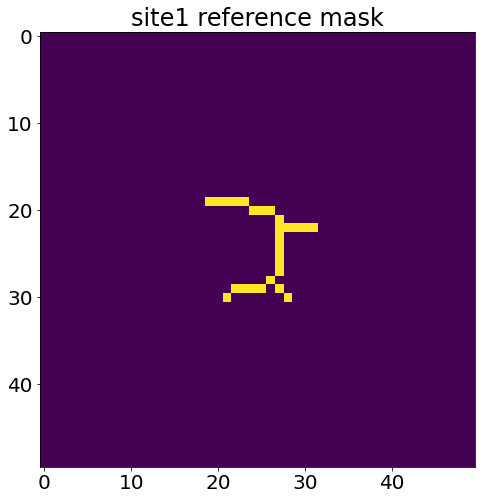

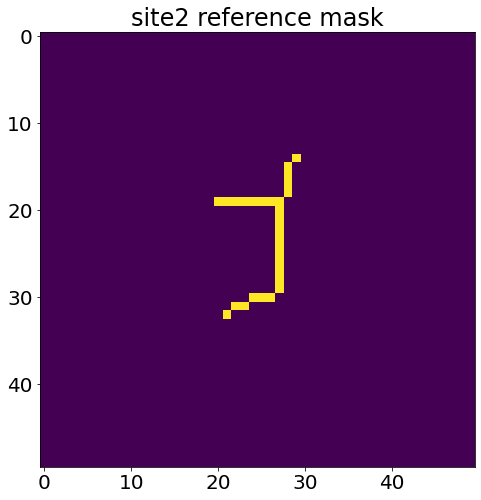

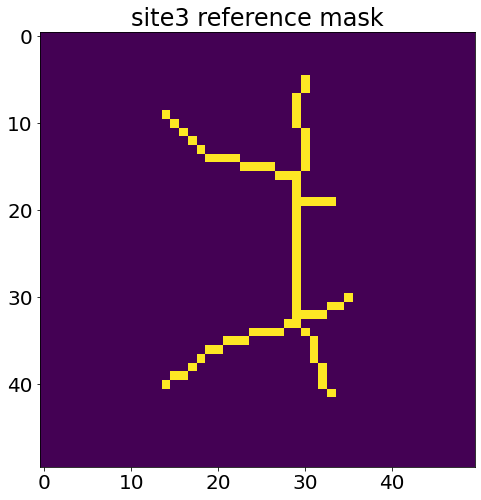

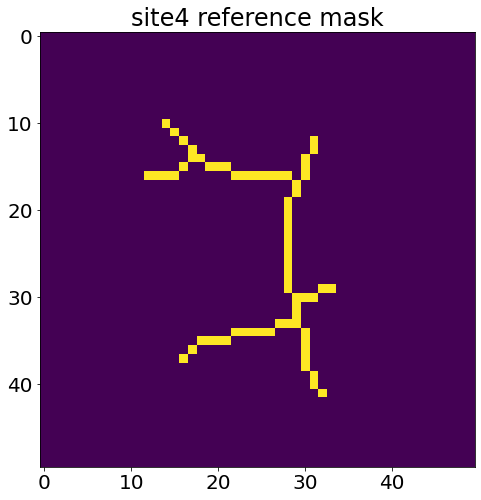

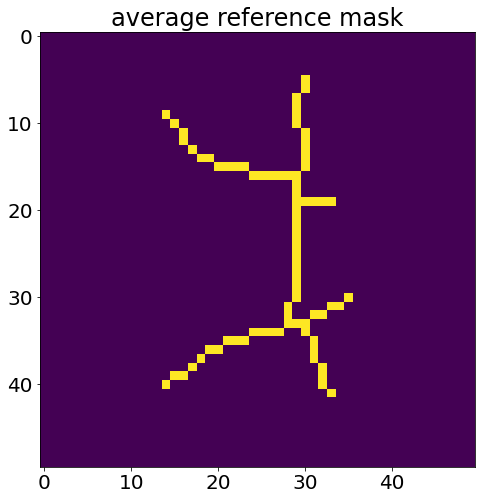

In [17]:
avg_mask_file = open(stat_folder_path+"average_masks.pkl", "rb")
avg_masks = pkl.load(avg_mask_file)
avg_mask_file.close()

for k in avg_masks.keys():
    plt.imshow(avg_masks[k])
    plt.title(k+" reference mask")
    plt.show()

4038.0 0.0


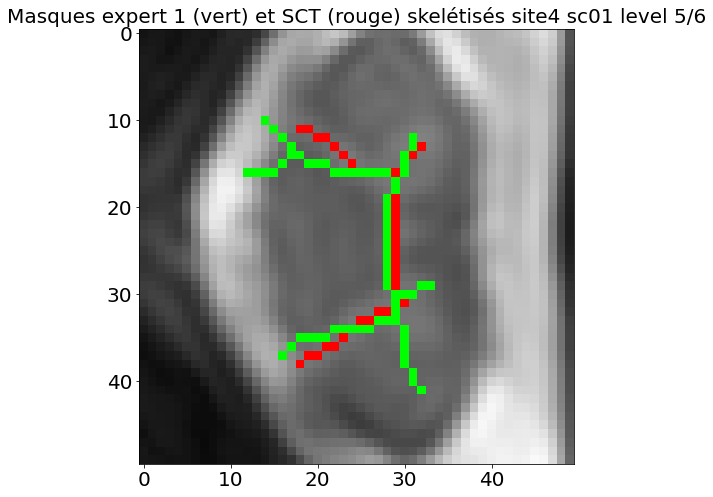

Distance de Hausdorff skeletisée :  9.486832980505138
Densité : 1781.1079812206572
Texute : 105.59263819729306


In [18]:
dm.plot_sklt_sct_masks_ref(ex_scan, avg_masks['site4'], mask=0, slice=0)

### Analyse des données d'entraînement

In [19]:
train_stat_file = open(stat_folder_path+"GM_feature_stats_train.pkl", "rb")
train_stat = pkl.load(train_stat_file)
train_stat_file.close()

for site in train_file_tree.keys():
    print(site)
    print('Densité moyenne :'+str(train_stat[site]['density']['mean'])+', écart type :'+str(train_stat[site]['density']['std']))
    print('Texture moyenne :'+str(train_stat[site]['texture']['mean'])+', écart type :'+str(train_stat[site]['texture']['std']))
    print('Ecart de forme moyen :'+str(train_stat[site]['shape']['mean'])+', écart type :'+str(train_stat[site]['shape']['std']))


df_train = pd.read_pickle(stat_folder_path+"GM_features_train.pkl")

df_train.head()

site1
Densité moyenne :1057.6005821486456, écart type :77.24711943241077
Texture moyenne :54.81236834479145, écart type :8.242674356087296
Ecart de forme moyen :3.237842754731173, écart type :0.6452707149986391
site2
Densité moyenne :479.358486377708, écart type :25.820155895384826
Texture moyenne :32.041244958617085, écart type :7.744777246020012
Ecart de forme moyen :5.588294447842101, écart type :1.6778596341255025
site3
Densité moyenne :219.05886905383457, écart type :72.38905866627387
Texture moyenne :10.9572107710199, écart type :3.4427497876507274
Ecart de forme moyen :10.461102390697778, écart type :2.6777484518410692
site4
Densité moyenne :1668.5866138299918, écart type :191.0962893972146
Texture moyenne :106.65902891310972, écart type :25.722372053459875
Ecart de forme moyen :8.207094002565011, écart type :1.5674950937346912


,SITE,SCAN,SLICE,LEVEL,DENSITY,TEXTURE,SHAPE
0,1,1,0,2,975.801698,52.517637,3.605551
1,1,1,1,2,988.574705,45.484808,2.236068
2,1,1,2,2,982.562035,47.924017,2.828427
3,1,2,0,2,1003.106916,81.958772,4.000000
4,1,2,1,2,997.923915,57.260305,4.000000


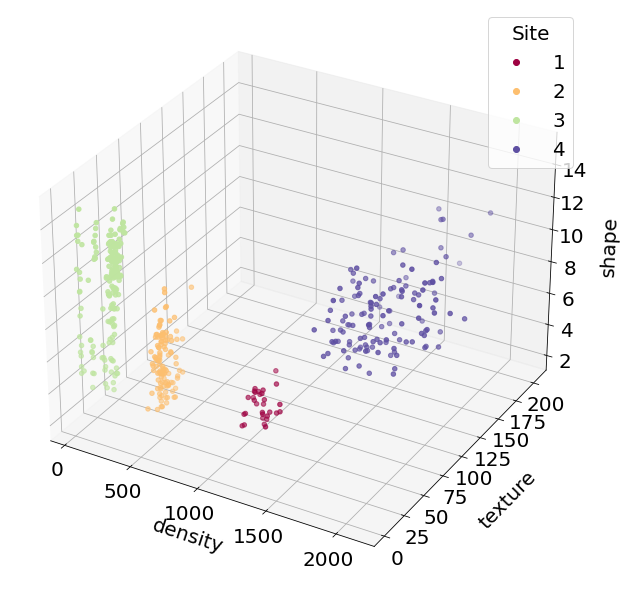

In [20]:
fig = plt.figure()
ax = Axes3D(fig)

scatter = ax.scatter(df_train.DENSITY.values, df_train.TEXTURE.values, df_train.SHAPE.values, c=df_train.SITE.values, cmap=plt.cm.Spectral)
ax.legend(*scatter.legend_elements(), title="Site")

ax.set_xlabel('density', labelpad=10)
ax.set_ylabel('texture', labelpad=20)
ax.set_zlabel('shape', labelpad=15)

plt.show()

On peut voir ici que les propriétés extraites de tranches de moelle épinière se regroupent par site car chacun utilise un scanner différent et donc est "calibré" différemment. 

On constate notamment que la densité de la moelle ainsi que la texture ont un faible écart type pour les site 1, 2 et 3. Sachant que tous les scanner concernent des patient sains il serait a priori assez facile de déter une anomalie sur un nouveau patient en comparant les propriétés extraites de sa moelle épinière aux valeurs moyenne de ces données d'entraînement.

On remarque cependant que les données du site 4 sont beaucoup plus bruitées. Cela peut être dû au fait que l'image obtenue a une définition augmentée par interpolation ou à un protocole d'acquisition avec plus de variations. Cela rend ces données plus difficiles à analyser.

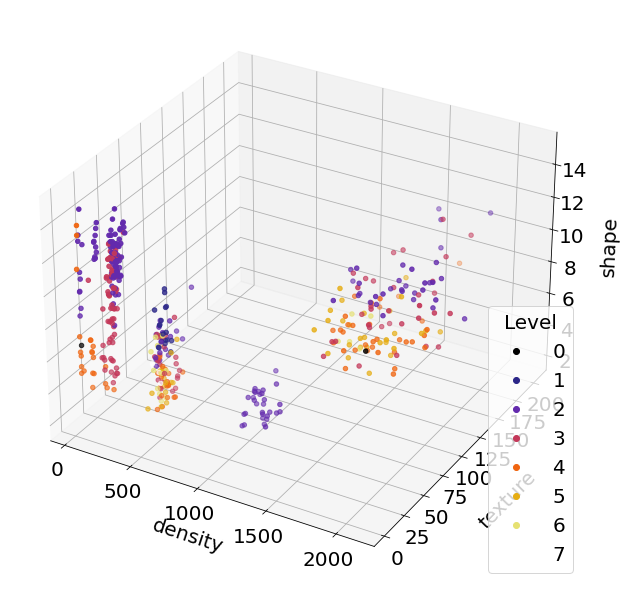

In [21]:
fig = plt.figure()
ax = Axes3D(fig)
scatter = ax.scatter(df_train.DENSITY.values, df_train.TEXTURE.values, df_train.SHAPE.values, c=df_train.LEVEL.values, cmap=plt.cm.CMRmap)
ax.legend(*scatter.legend_elements(), title="Level")

ax.set_xlabel('density', labelpad=10)
ax.set_ylabel('texture', labelpad=20)
ax.set_zlabel('shape', labelpad=15)

plt.show()

On remarque une certaine corrélation entre la distance au masque de référence et le niveau de là tranche d'IRM. Afin d'avoir une détection de déformation plus éfficace il serait souhaitable d'avoir un squelette de référence par cervicale. 

On remarque par ailleurs que le rapport des valeurs moyennes densité/texture des 4 sites est relativement constant autour de 20 (19.5, 14.9, 19.9 et 15.7 respectivement), de plus la valeur moyenne de la densité du site 2 (479) et égale au double de la densité du site 3 (219) sachant que les deux sites utilisent un scanner Simmens mais que les tranche du site 3 sont 2 fois plus finnes. Il serait donc peut être possible de normaliser les propriété extraites des IRMS en étudiant les propriété des canners utilisés.

### Analyse des données test

In [22]:
test_stat_file = open(stat_folder_path+"GM_feature_stats_test.pkl", "rb")
test_stat = pkl.load(test_stat_file)
test_stat_file.close()

for site in train_file_tree.keys():
    print(site)
    print('Densité moyenne :'+str(test_stat[site]['density']['mean'])+', écart type :'+str(test_stat[site]['density']['std']))
    print('Texture moyenne :'+str(test_stat[site]['texture']['mean'])+', écart type :'+str(test_stat[site]['texture']['std']))
    print('Ecart de forme moyen :'+str(test_stat[site]['shape']['mean'])+', écart type :'+str(test_stat[site]['shape']['std']))


df_test = pd.read_pickle(stat_folder_path+"GM_features_test.pkl")

df_test.head()

site1
Densité moyenne :1078.5056152624798, écart type :68.52519020913776
Texture moyenne :56.08005194490933, écart type :11.99568407630008
Ecart de forme moyen :3.1378981319553727, écart type :0.6734948503670852
site2
Densité moyenne :451.52492395062427, écart type :33.90920076417519
Texture moyenne :29.81319649545174, écart type :5.985050651163837
Ecart de forme moyen :5.743490308466626, écart type :1.7933774203149717
site3
Densité moyenne :218.48261885086546, écart type :70.7351029691041
Texture moyenne :11.57356223280339, écart type :4.556587728454363
Ecart de forme moyen :11.337731058269256, écart type :2.656853312799485
site4
Densité moyenne :1618.8560897175932, écart type :129.5851438748779
Texture moyenne :109.4632577043987, écart type :24.792639016250437
Ecart de forme moyen :8.477589930930806, écart type :1.5477792084571016


,SITE,SCAN,SLICE,LEVEL,DENSITY,TEXTURE,SHAPE
0,1,11,0,2,1065.863732,48.206531,3.000000
1,1,11,1,2,1083.721308,46.094483,2.236068
2,1,11,2,2,1097.264652,47.606924,3.000000
3,1,12,0,2,1026.161334,46.238612,1.414214
4,1,12,1,2,1035.779412,40.005050,2.828427


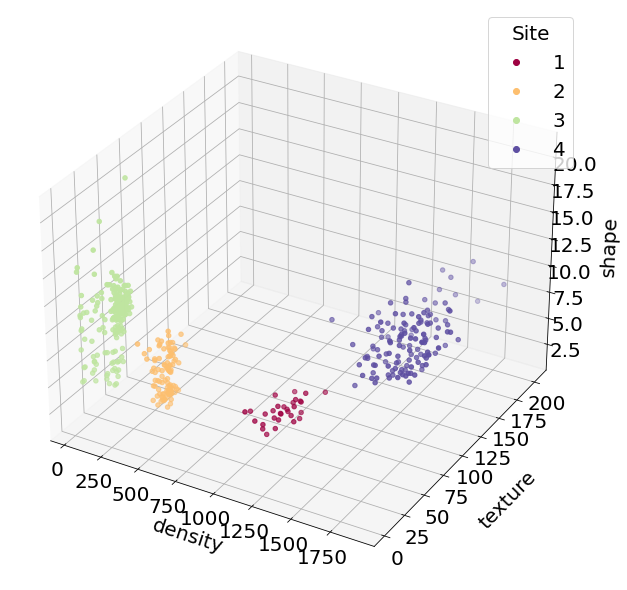

In [23]:
fig = plt.figure()
ax = Axes3D(fig)

scatter = ax.scatter(df_test.DENSITY.values, df_test.TEXTURE.values, df_test.SHAPE.values, c=df_test.SITE.values, cmap=plt.cm.Spectral)
ax.legend(*scatter.legend_elements(), title="Site")

ax.set_xlabel('density', labelpad=10)
ax.set_ylabel('texture', labelpad=20)
ax.set_zlabel('shape', labelpad=15)

plt.show()

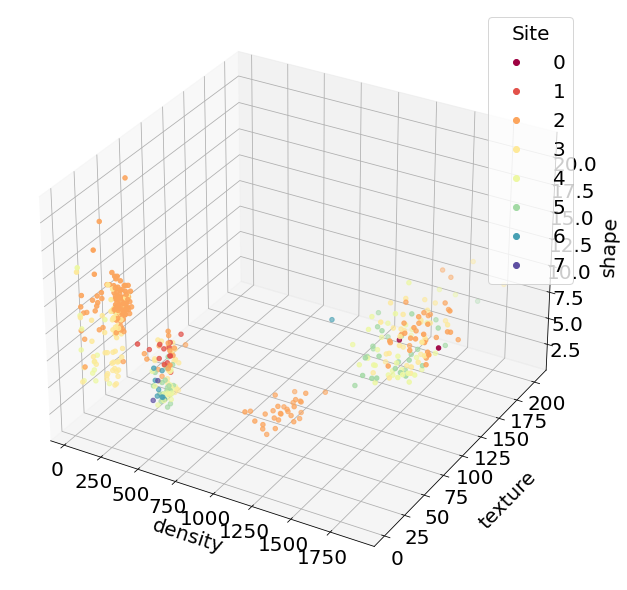

In [24]:
fig = plt.figure()
ax = Axes3D(fig)

scatter = ax.scatter(df_test.DENSITY.values, df_test.TEXTURE.values, df_test.SHAPE.values, c=df_test.LEVEL.values, cmap=plt.cm.Spectral)
ax.legend(*scatter.legend_elements(), title="Site")

ax.set_xlabel('density', labelpad=10)
ax.set_ylabel('texture', labelpad=20)
ax.set_zlabel('shape', labelpad=15)

plt.show()

In [25]:
print("écart des moyennes de densité entre training et test : ", 200*(abs(test_stat[site]['density']['mean'] - train_stat[site]['density']['mean']))/(test_stat[site]['density']['mean'] + train_stat[site]['density']['mean']), '%')
print("écart des moyennes de texture entre training et test : ", 200*(abs(test_stat[site]['texture']['mean'] - train_stat[site]['texture']['mean']))/(test_stat[site]['texture']['mean'] + train_stat[site]['texture']['mean']), '%')
print("écart des moyennes de distance à la forme de référence entre training et test : ", 200*(abs(test_stat[site]['shape']['mean'] - train_stat[site]['shape']['mean']))/(test_stat[site]['shape']['mean'] + train_stat[site]['shape']['mean']), '%')

écart des moyennes de densité entre training et test :  3.025483854592069 %
écart des moyennes de texture entre training et test :  2.595038980178736 %
écart des moyennes de distance à la forme de référence entre training et test :  3.2424459395692042 %


On retrouve des résultats très proches de ceux obtenus sur les données d'entraînement ce qui assure la robustesse de la segmentation SCT.

# Conclusion

Cette étude a prouvé l'efficacité de Spinal Cord Toolbox pour la segmentation de moelle épinière sur des tranches IRM obtenues de plusieurs scanners différents. Afin d'en tirer un outil efficace de détection d'anomalies et d'aide au diagnostic, il faudrait encore consulter l'avis d'un spécialiste et établir un protocole d'acquisition d'IRM standardisé afin de pouvoir affiner le modèle et augmenter la qualité des données.

Plusieurs pistes d'amélioration possibles :

- L'affinage du modèle sur des masques expert plus précis, on a pu constater des divergences assez importantes dans les masques expert, avoir une référence solide permettra d'extraire des propriété plus sensibles aux variations de la segmentation tels que le volume total de moelle épinière.

- Se pencher sur la normalisation des données afin que le modèle puisse être déployé sur n'importe quelle machine à en utilisant ses caractéristiques techniques.

- Enrichire les données, récuppérer l'âge, le sexe, la tailles etc. des sujets de l'IRM et déterminer d'avantages de métriques pertinantes permettera d'affiner d'avantage l'analyse des données.